In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [25]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [26]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['book_title', 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [27]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [28]:
books['category_high'].value_counts()

fiction                                            39678
biography autobiography                             3326
history                                             1927
religion                                            1824
nonfiction                                          1427
                                                   ...  
buddhismus                                             1
heller jettero fictitious character                    1
persian gulf                                           1
procedure law                                          1
authors canadian english 20th century biography        1
Name: category_high, Length: 3270, dtype: int64

In [29]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [30]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [31]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [32]:
# users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
# users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
# users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
# users = users.drop(['location'], axis=1)

# loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
# loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
# loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

# users['location_city'] = users['location_city'].map(loc_city2idx)
# users['location_state'] = users['location_state'].map(loc_state2idx)
# users['location_country'] = users['location_country'].map(loc_country2idx)

In [33]:
# # users 테이블 전처리 입니다.
# # location이 지역, 주, 국가로 되어있어 이 부분 기초 전처리 진행 과정입니다.

# users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

# # 지역, 주, 국가
# users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
# users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
# users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

# users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
# users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# # 도시는 존재하는데 나라 정보가 없는 경우 채워주는 코드
# modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
# location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

# location_list = []
# for location in modify_location:
#     try:
#         right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
#         location_list.append(right_location)
#     except:
#         pass

# for location in location_list:
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [34]:
# # 저는 도시, 주, 국가 중 주를 선택했습니다.
# # 우선 모든 변수를 다 쓰는 건 아니라고 생각했어요. 도시 < 주 < 국가로 포함관계가 있기 때문이죠.
# # 데이터 분석 결과 주와 국가 단위가 비슷한 경우가 많은 것을 확인했습니다.
# # 조그만 섬 국가 < 미국 켈리포니아 주 < 미국 같은 경우죠.
# # 미국 같은 경우 미국으로 뭉뚱그리기 보다 주 단위로 나누는 것이 맞다고 판단했습니다.
# # 실제 미국 주 별로 rating 차이가 꽤 존재합니다.
# # 다만 도시 기준으로 나누면 너무 세분화 될 것 같다는 생각이 들었습니다.
# # 결론적으로 주를 지역을 나타내는 변수로 사용하기로 하고 결측값을 도시, 나라에서 채우기로 했습니다.

# def _fillna(x):
#     if pd.isna(x['location_country']):
#         # 만약 나라가 기록 안되있는 경우        
#         if pd.isna(x['location_city']):
#             # 도시까지 없다면 모든 정보가 없음. 최빈값 california 사용.
#             return 'california'
#         else:
#             tem = users['location_state'][users['location_city'] == x['location_city']].value_counts()
#             if len(tem) == 0: 
#                 # 만약 주 이름이 없는 도시이면 도시 이름을 주 이름으로 사용.
#                 return x['location_city'] 
#             else:
#                 # 그 도시에서 가장 자주 쓰이는 주 이름 사용.
#                 return tem.index[0]

#     else:
#         tem = users['location_state'][users['location_country'] == x['location_country']].value_counts()
#         if len(tem) == 0: 
#             # 만약 주 이름이 없는 나라이면 나라이름을 주 이름으로 사용.
#             return x['location_country'] 
#         else:
#             # 그 나라에서 가장 자주 쓰이는 주 이름 사용.
#             return tem.index[0]

# users['fix_location_state'] = users.apply(lambda x : _fillna(x) if pd.isna(x['location_state']) else x['location_state'], axis = 1)

In [35]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [36]:
# users2 = pd.read_csv(path+'users.csv')
# users['age'] = users2['age']

In [37]:
# def age_map(x: int) -> int:
#     x = int(x)
#     if x < 20:
#         return 1
#     elif x >= 20 and x < 30:
#         return 2
#     elif x >= 30 and x < 40:
#         return 3
#     elif x >= 40 and x < 50:
#         return 4
#     elif x >= 50 and x < 60:
#         return 5
#     else:
#         return 6

# users['age'] = users['age'].fillna(users['age'].mean())
# users['age'] = users['age'].apply(age_map)

# users['age'].value_counts()

In [38]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


In [39]:
# n = 1

# def make_others(_column):
#     tem = pd.DataFrame(users[_column].value_counts()).reset_index()
#     tem.columns = ['names','count']
#     others_list = tem[tem['count'] <= n]['names'].values  # n은 초기에 설정함. 바꿀 수 있음.
#     users.loc[users[users[_column].isin(others_list)].index, _column]= 'others'

# def make_others2(_column):
#     tem = pd.DataFrame(books[_column].value_counts()).reset_index()
#     tem.columns = ['names','count']
#     others_list = tem[tem['count'] <= n]['names'].values  # n은 초기에 설정함. 바꿀 수 있음.
#     books.loc[books[books[_column].isin(others_list)].index, _column]= 'others'

# make_others('location_city')
# make_others('location_state')
# make_others('location_country')

# make_others2('book_author')
# make_others2('publisher')
# make_others2('category_high')

## rating 테이블과 merge

In [40]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')


In [41]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 315083
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           306795 non-null  object 
 1   isbn              306795 non-null  object 
 2   rating            306795 non-null  float64
 3   book_author       306795 non-null  object 
 4   publisher         306795 non-null  object 
 5   language          306795 non-null  object 
 6   category_high     306795 non-null  object 
 7   years             306795 non-null  object 
 8   location_city     306795 non-null  object 
 9   location_state    306795 non-null  object 
 10  location_country  306795 non-null  object 
 11  fix_age           306795 non-null  object 
dtypes: float64(1), object(11)
memory usage: 30.4+ MB


# 모델링

In [42]:
# params_cat = {
#             "task_type" : "GPU",
#             "devices" : '0',
#             "random_state": SEED,
#             "learning_rate": 0.05,
#             "n_estimators": 2000,
#             "verbose" : 1,
#             "objective" : "RMSE",
#             "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#             "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#             #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#             "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#             "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#             "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns)
#     }

params_cat = {
    "task_type" : "GPU",
    "devices" : '0',
    "random_state": SEED,
    'learning_rate': 0.04574578205475402, 
    'bagging_temperature': 0.12172958098369972, 
    'n_estimators': 8459, 
    'max_depth': 8, 
    'random_strength': 28, 
    'l2_leaf_reg': 1.6285455533915874e-05, 
    'min_child_samples': 18, 
    'max_bin': 441, 
    'od_type': 'Iter',
    "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

X_tr, X_val, y_tr, y_val = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2,random_state= 42)

model = CatBoostRegressor(**params_cat)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=False,
)

cat_pred = model.predict(X_val)
log_score = rmse(y_val, cat_pred)

print(log_score)

2.1367905496104806


In [43]:
X_val['rating'] = y_val
X_val['pred'] = cat_pred
X_val.to_csv('../cat_va2.csv', index = False)

In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
  folds.append((train_idx,valid_idx))

In [19]:
random.seed(SEED)
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(0,5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'],axis = 1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'],axis = 1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', devices = '0', random_state = SEED, objective = 'RMSE', cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================


[I 2022-11-02 01:27:09,863] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327258	test: 2.4326954	best: 2.4326954 (0)	total: 14.5ms	remaining: 1m 50s
100:	learn: 2.4275738	test: 2.4260062	best: 2.4260062 (100)	total: 1.29s	remaining: 1m 35s
200:	learn: 2.4275730	test: 2.4259895	best: 2.4259895 (200)	total: 2.53s	remaining: 1m 32s
bestTest = 2.425989346
bestIteration = 202
Shrink model to first 203 iterations.


[I 2022-11-02 01:27:15,231] Trial 0 finished with value: 2.4259896308111 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4259896308111.


0:	learn: 2.4330812	test: 2.4331112	best: 2.4331112 (0)	total: 13.6ms	remaining: 1m 55s
100:	learn: 2.4281970	test: 2.4270987	best: 2.4270987 (100)	total: 1.29s	remaining: 1m 47s
200:	learn: 2.4276433	test: 2.4262171	best: 2.4262171 (200)	total: 2.54s	remaining: 1m 44s
300:	learn: 2.4275813	test: 2.4260494	best: 2.4260494 (300)	total: 3.79s	remaining: 1m 43s
400:	learn: 2.4275738	test: 2.4260075	best: 2.4260075 (400)	total: 5.07s	remaining: 1m 42s
500:	learn: 2.4275730	test: 2.4259954	best: 2.4259954 (499)	total: 6.34s	remaining: 1m 41s
600:	learn: 2.4275726	test: 2.4259916	best: 2.4259916 (596)	total: 7.6s	remaining: 1m 39s
700:	learn: 2.4275732	test: 2.4259901	best: 2.4259900 (687)	total: 8.87s	remaining: 1m 38s
800:	learn: 2.4275730	test: 2.4259895	best: 2.4259895 (800)	total: 10.1s	remaining: 1m 37s
900:	learn: 2.4275731	test: 2.4259896	best: 2.4259895 (800)	total: 11.3s	remaining: 1m 35s
1000:	learn: 2.4275731	test: 2.4259896	best: 2.4259895 (800)	total: 12.6s	remaining: 1m 33s
11

[I 2022-11-02 01:29:02,529] Trial 1 finished with value: 2.425989805259032 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4259896308111.


0:	learn: 2.4034971	test: 2.3974901	best: 2.3974901 (0)	total: 26.9ms	remaining: 1m 37s
100:	learn: 2.1902942	test: 2.1483797	best: 2.1483797 (100)	total: 2.57s	remaining: 1m 29s
200:	learn: 2.1665903	test: 2.1404201	best: 2.1403277 (198)	total: 4.87s	remaining: 1m 23s
300:	learn: 2.1477126	test: 2.1378417	best: 2.1378225 (299)	total: 7.21s	remaining: 1m 19s
400:	learn: 2.1319113	test: 2.1362055	best: 2.1362055 (400)	total: 9.61s	remaining: 1m 17s
500:	learn: 2.1187814	test: 2.1362513	best: 2.1361534 (424)	total: 12s	remaining: 1m 14s
600:	learn: 2.1051866	test: 2.1358513	best: 2.1358386 (528)	total: 14.2s	remaining: 1m 11s
700:	learn: 2.0929800	test: 2.1357376	best: 2.1356565 (663)	total: 16.5s	remaining: 1m 8s
800:	learn: 2.0820667	test: 2.1357481	best: 2.1356165 (719)	total: 18.8s	remaining: 1m 6s
900:	learn: 2.0696859	test: 2.1358055	best: 2.1356165 (719)	total: 21.1s	remaining: 1m 3s
1000:	learn: 2.0585122	test: 2.1361705	best: 2.1356165 (719)	total: 23.6s	remaining: 1m 1s
1100:	l

[I 2022-11-02 01:30:32,650] Trial 2 finished with value: 2.1356163956086616 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1356163956086616.


0:	learn: 2.4006965	test: 2.4015856	best: 2.4015856 (0)	total: 456ms	remaining: 12m 1s
100:	learn: 1.9740325	test: 2.1490296	best: 2.1489285 (93)	total: 45.6s	remaining: 11m 9s
200:	learn: 1.4933102	test: 2.1635404	best: 2.1478504 (120)	total: 1m 31s	remaining: 10m 27s
300:	learn: 1.0729629	test: 2.1864787	best: 2.1478504 (120)	total: 2m 16s	remaining: 9m 44s
400:	learn: 0.8245635	test: 2.2016215	best: 2.1478504 (120)	total: 3m 3s	remaining: 9m
500:	learn: 0.6722053	test: 2.2110905	best: 2.1478504 (120)	total: 3m 49s	remaining: 8m 15s
600:	learn: 0.5584588	test: 2.2174260	best: 2.1478504 (120)	total: 4m 35s	remaining: 7m 30s
700:	learn: 0.4668260	test: 2.2228251	best: 2.1478504 (120)	total: 5m 20s	remaining: 6m 44s
800:	learn: 0.3998475	test: 2.2267289	best: 2.1478504 (120)	total: 6m 6s	remaining: 5m 58s
900:	learn: 0.3498684	test: 2.2296122	best: 2.1478504 (120)	total: 6m 52s	remaining: 5m 13s
1000:	learn: 0.3072555	test: 2.2319409	best: 2.1478504 (120)	total: 7m 38s	remaining: 4m 27s

[I 2022-11-02 01:42:42,710] Trial 3 finished with value: 2.1478501804713135 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1356163956086616.


0:	learn: 2.4273529	test: 2.4270871	best: 2.4270871 (0)	total: 244ms	remaining: 5m 19s
100:	learn: 2.1943117	test: 2.1964592	best: 2.1964592 (100)	total: 24.6s	remaining: 4m 53s
200:	learn: 2.1216849	test: 2.1576626	best: 2.1576626 (200)	total: 49.5s	remaining: 4m 32s
300:	learn: 2.0842722	test: 2.1472220	best: 2.1472220 (300)	total: 1m 14s	remaining: 4m 8s
400:	learn: 2.0497892	test: 2.1427099	best: 2.1427099 (400)	total: 1m 38s	remaining: 3m 43s
500:	learn: 2.0202154	test: 2.1402554	best: 2.1402554 (500)	total: 2m 3s	remaining: 3m 18s
600:	learn: 1.9879504	test: 2.1384529	best: 2.1384529 (600)	total: 2m 27s	remaining: 2m 54s
700:	learn: 1.9570221	test: 2.1372481	best: 2.1372481 (700)	total: 2m 52s	remaining: 2m 29s
800:	learn: 1.9202723	test: 2.1363757	best: 2.1363757 (800)	total: 3m 17s	remaining: 2m 5s
900:	learn: 1.8677433	test: 2.1356930	best: 2.1356930 (900)	total: 3m 41s	remaining: 1m 40s
1000:	learn: 1.7928691	test: 2.1355600	best: 2.1353498 (952)	total: 4m 5s	remaining: 1m 15

[I 2022-11-02 01:48:14,717] Trial 4 finished with value: 2.1353498820461305 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1353498820461305.


0:	learn: 2.3732099	test: 2.3812418	best: 2.3812418 (0)	total: 243ms	remaining: 38m 16s
bestTest = 2.286290195
bestIteration = 43
Shrink model to first 44 iterations.


[I 2022-11-02 01:48:33,228] Trial 5 finished with value: 2.2862901188015545 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1353498820461305.


0:	learn: 2.4204218	test: 2.4178928	best: 2.4178928 (0)	total: 28.5ms	remaining: 4m 1s
100:	learn: 2.2053832	test: 2.1616256	best: 2.1616256 (100)	total: 2.53s	remaining: 3m 29s
200:	learn: 2.1906678	test: 2.1494872	best: 2.1494872 (200)	total: 5.2s	remaining: 3m 33s
300:	learn: 2.1824540	test: 2.1453114	best: 2.1453114 (300)	total: 7.81s	remaining: 3m 31s
400:	learn: 2.1714751	test: 2.1412842	best: 2.1412842 (400)	total: 10.1s	remaining: 3m 23s
500:	learn: 2.1613383	test: 2.1390220	best: 2.1390178 (499)	total: 12.3s	remaining: 3m 15s
600:	learn: 2.1534759	test: 2.1376662	best: 2.1376662 (600)	total: 14.8s	remaining: 3m 13s
700:	learn: 2.1463747	test: 2.1369338	best: 2.1369338 (700)	total: 17.2s	remaining: 3m 9s
800:	learn: 2.1395365	test: 2.1361435	best: 2.1361385 (799)	total: 19.6s	remaining: 3m 6s
900:	learn: 2.1336841	test: 2.1356940	best: 2.1356940 (900)	total: 22s	remaining: 3m 4s
1000:	learn: 2.1277873	test: 2.1353222	best: 2.1353222 (1000)	total: 24s	remaining: 2m 59s
1100:	lea

[I 2022-11-02 01:49:05,281] Trial 6 finished with value: 2.134634340561801 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.134634340561801.


0:	learn: 2.3702405	test: 2.3606565	best: 2.3606565 (0)	total: 139ms	remaining: 2m 25s
100:	learn: 1.8564567	test: 2.1632829	best: 2.1500289 (60)	total: 14.3s	remaining: 2m 13s
200:	learn: 1.4039639	test: 2.2010799	best: 2.1500289 (60)	total: 28s	remaining: 1m 58s
300:	learn: 1.0983602	test: 2.2288670	best: 2.1500289 (60)	total: 42.2s	remaining: 1m 44s
400:	learn: 0.9001173	test: 2.2457696	best: 2.1500289 (60)	total: 56s	remaining: 1m 30s
500:	learn: 0.7520152	test: 2.2570666	best: 2.1500289 (60)	total: 1m 9s	remaining: 1m 16s
600:	learn: 0.6289770	test: 2.2655146	best: 2.1500289 (60)	total: 1m 23s	remaining: 1m 2s
700:	learn: 0.5368567	test: 2.2725521	best: 2.1500289 (60)	total: 1m 37s	remaining: 48.4s
800:	learn: 0.4657439	test: 2.2769858	best: 2.1500289 (60)	total: 1m 51s	remaining: 34.5s
900:	learn: 0.4070376	test: 2.2813325	best: 2.1500289 (60)	total: 2m 4s	remaining: 20.5s
1000:	learn: 0.3623705	test: 2.2840942	best: 2.1500289 (60)	total: 2m 18s	remaining: 6.65s
1048:	learn: 0.34

[I 2022-11-02 01:51:34,098] Trial 7 finished with value: 2.1500289797784062 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.134634340561801.


0:	learn: 2.3683738	test: 2.3559918	best: 2.3559918 (0)	total: 13.9ms	remaining: 55.1s
100:	learn: 2.2066022	test: 2.1579836	best: 2.1579836 (100)	total: 1.6s	remaining: 1m 1s
200:	learn: 2.2010202	test: 2.1548558	best: 2.1548558 (200)	total: 3.19s	remaining: 59.9s
300:	learn: 2.1972501	test: 2.1531622	best: 2.1531622 (300)	total: 4.72s	remaining: 57.6s
400:	learn: 2.1936891	test: 2.1521371	best: 2.1521332 (399)	total: 6.2s	remaining: 55.3s
500:	learn: 2.1908437	test: 2.1512818	best: 2.1512714 (499)	total: 7.63s	remaining: 53s
600:	learn: 2.1878495	test: 2.1505472	best: 2.1505472 (600)	total: 9.07s	remaining: 51s
700:	learn: 2.1851532	test: 2.1493705	best: 2.1493565 (699)	total: 10.5s	remaining: 49.1s
800:	learn: 2.1827077	test: 2.1488874	best: 2.1488872 (799)	total: 11.9s	remaining: 47.2s
900:	learn: 2.1804976	test: 2.1488198	best: 2.1486996 (880)	total: 13.3s	remaining: 45.5s
1000:	learn: 2.1782422	test: 2.1482679	best: 2.1482012 (982)	total: 14.7s	remaining: 43.7s
1100:	learn: 2.176

[I 2022-11-02 01:52:35,189] Trial 8 finished with value: 2.147376374967213 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.134634340561801.


0:	learn: 2.4294126	test: 2.4288982	best: 2.4288982 (0)	total: 42ms	remaining: 5m 29s
100:	learn: 2.2727943	test: 2.2656955	best: 2.2656955 (100)	total: 4.17s	remaining: 5m 19s
200:	learn: 2.2266646	test: 2.2284818	best: 2.2284818 (200)	total: 8.29s	remaining: 5m 15s
300:	learn: 2.2009200	test: 2.2149961	best: 2.2149961 (300)	total: 12.4s	remaining: 5m 11s
400:	learn: 2.1801164	test: 2.2061260	best: 2.2061260 (400)	total: 16.6s	remaining: 5m 7s
500:	learn: 2.1622758	test: 2.2003707	best: 2.2003688 (499)	total: 20.6s	remaining: 5m 2s
600:	learn: 2.1451034	test: 2.1955815	best: 2.1955815 (600)	total: 24.8s	remaining: 4m 58s
700:	learn: 2.1297882	test: 2.1920693	best: 2.1920655 (698)	total: 28.9s	remaining: 4m 54s
800:	learn: 2.1169220	test: 2.1898393	best: 2.1898365 (799)	total: 33.1s	remaining: 4m 50s
900:	learn: 2.1035399	test: 2.1882126	best: 2.1882126 (900)	total: 37.2s	remaining: 4m 46s
1000:	learn: 2.0909078	test: 2.1864115	best: 2.1864115 (1000)	total: 41.4s	remaining: 4m 42s
1100

[I 2022-11-02 01:53:29,258] Trial 9 finished with value: 2.184237924461932 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.134634340561801.


0:	learn: 2.4204218	total: 26.4ms	remaining: 3m 43s
1:	learn: 2.4099554	total: 48.8ms	remaining: 3m 26s
2:	learn: 2.3986359	total: 72.3ms	remaining: 3m 23s
3:	learn: 2.3884323	total: 94.1ms	remaining: 3m 18s
4:	learn: 2.3785808	total: 116ms	remaining: 3m 16s
5:	learn: 2.3689140	total: 139ms	remaining: 3m 16s
6:	learn: 2.3616031	total: 162ms	remaining: 3m 15s
7:	learn: 2.3551494	total: 184ms	remaining: 3m 14s
8:	learn: 2.3483268	total: 209ms	remaining: 3m 16s
9:	learn: 2.3411997	total: 241ms	remaining: 3m 23s
10:	learn: 2.3357858	total: 266ms	remaining: 3m 23s
11:	learn: 2.3296211	total: 288ms	remaining: 3m 22s
12:	learn: 2.3230037	total: 314ms	remaining: 3m 23s
13:	learn: 2.3178668	total: 338ms	remaining: 3m 23s
14:	learn: 2.3131404	total: 361ms	remaining: 3m 23s
15:	learn: 2.3080808	total: 382ms	remaining: 3m 21s
16:	learn: 2.3038042	total: 407ms	remaining: 3m 22s
17:	learn: 2.2999544	total: 433ms	remaining: 3m 23s
18:	learn: 2.2958604	total: 461ms	remaining: 3m 24s
19:	learn: 2.29255

[I 2022-11-02 01:57:01,407] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327672	test: 2.4325286	best: 2.4325286 (0)	total: 12.5ms	remaining: 1m 35s
100:	learn: 2.4275791	test: 2.4260900	best: 2.4260900 (100)	total: 1.23s	remaining: 1m 30s
200:	learn: 2.4275778	test: 2.4260772	best: 2.4260771 (191)	total: 2.5s	remaining: 1m 32s
bestTest = 2.426076782
bestIteration = 223
Shrink model to first 224 iterations.


[I 2022-11-02 01:57:06,950] Trial 0 finished with value: 2.4260770198204833 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4260770198204833.


0:	learn: 2.4331245	test: 2.4329368	best: 2.4329368 (0)	total: 13.5ms	remaining: 1m 54s
100:	learn: 2.4282068	test: 2.4270919	best: 2.4270919 (100)	total: 1.28s	remaining: 1m 46s
200:	learn: 2.4276497	test: 2.4262720	best: 2.4262720 (200)	total: 2.56s	remaining: 1m 45s
300:	learn: 2.4275868	test: 2.4261259	best: 2.4261259 (300)	total: 3.83s	remaining: 1m 44s
400:	learn: 2.4275794	test: 2.4260918	best: 2.4260916 (399)	total: 5.08s	remaining: 1m 42s
500:	learn: 2.4275784	test: 2.4260815	best: 2.4260815 (500)	total: 6.33s	remaining: 1m 40s
600:	learn: 2.4275783	test: 2.4260785	best: 2.4260785 (589)	total: 7.58s	remaining: 1m 39s
700:	learn: 2.4275778	test: 2.4260775	best: 2.4260775 (700)	total: 8.83s	remaining: 1m 38s
800:	learn: 2.4275778	test: 2.4260770	best: 2.4260770 (794)	total: 10.1s	remaining: 1m 36s
900:	learn: 2.4275778	test: 2.4260772	best: 2.4260770 (794)	total: 11.3s	remaining: 1m 35s
1000:	learn: 2.4275778	test: 2.4260772	best: 2.4260770 (794)	total: 12.6s	remaining: 1m 34s
1

[I 2022-11-02 01:59:07,393] Trial 1 finished with value: 2.426077106051661 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4260770198204833.


0:	learn: 2.4031356	test: 2.3980055	best: 2.3980055 (0)	total: 30.2ms	remaining: 1m 49s
100:	learn: 2.1883449	test: 2.1543910	best: 2.1543910 (100)	total: 3.49s	remaining: 2m 1s
200:	learn: 2.1645095	test: 2.1457871	best: 2.1457871 (200)	total: 7.06s	remaining: 2m
300:	learn: 2.1468463	test: 2.1432739	best: 2.1432681 (299)	total: 10s	remaining: 1m 50s
400:	learn: 2.1313318	test: 2.1418779	best: 2.1418779 (400)	total: 14s	remaining: 1m 53s
500:	learn: 2.1175134	test: 2.1411507	best: 2.1410817 (497)	total: 17.4s	remaining: 1m 48s
600:	learn: 2.1042707	test: 2.1407521	best: 2.1407334 (599)	total: 20.5s	remaining: 1m 43s
700:	learn: 2.0908233	test: 2.1405500	best: 2.1403500 (647)	total: 23.3s	remaining: 1m 37s
800:	learn: 2.0788350	test: 2.1404579	best: 2.1403500 (647)	total: 27.1s	remaining: 1m 35s
900:	learn: 2.0676425	test: 2.1409781	best: 2.1403500 (647)	total: 29.9s	remaining: 1m 30s
1000:	learn: 2.0563482	test: 2.1412960	best: 2.1403500 (647)	total: 33.9s	remaining: 1m 28s
1100:	lear

[I 2022-11-02 02:01:01,340] Trial 2 finished with value: 2.140350120328913 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.140350120328913.


0:	learn: 2.4017608	test: 2.4024970	best: 2.4024970 (0)	total: 477ms	remaining: 12m 35s
100:	learn: 1.9906215	test: 2.1530762	best: 2.1527199 (97)	total: 50.9s	remaining: 12m 27s
200:	learn: 1.5243648	test: 2.1679383	best: 2.1511964 (136)	total: 1m 41s	remaining: 11m 40s
300:	learn: 1.1015986	test: 2.1948018	best: 2.1511964 (136)	total: 2m 33s	remaining: 10m 55s
400:	learn: 0.8562349	test: 2.2098948	best: 2.1511964 (136)	total: 3m 27s	remaining: 10m 13s
500:	learn: 0.6871157	test: 2.2212593	best: 2.1511964 (136)	total: 4m 20s	remaining: 9m 24s
600:	learn: 0.5737479	test: 2.2278242	best: 2.1511964 (136)	total: 5m 11s	remaining: 8m 30s
700:	learn: 0.4731445	test: 2.2337808	best: 2.1511964 (136)	total: 6m 2s	remaining: 7m 37s
800:	learn: 0.4091776	test: 2.2373133	best: 2.1511964 (136)	total: 6m 52s	remaining: 6m 44s
900:	learn: 0.3574940	test: 2.2405635	best: 2.1511964 (136)	total: 7m 43s	remaining: 5m 52s
1000:	learn: 0.3160636	test: 2.2429055	best: 2.1511964 (136)	total: 8m 35s	remainin

[I 2022-11-02 02:14:52,814] Trial 3 finished with value: 2.1511962487748395 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.140350120328913.


0:	learn: 2.4273537	test: 2.4270596	best: 2.4270596 (0)	total: 273ms	remaining: 5m 57s
100:	learn: 2.1960972	test: 2.2008965	best: 2.2008965 (100)	total: 28.4s	remaining: 5m 39s
200:	learn: 2.1258507	test: 2.1622122	best: 2.1622122 (200)	total: 56.9s	remaining: 5m 13s
300:	learn: 2.0874454	test: 2.1515970	best: 2.1515970 (300)	total: 1m 25s	remaining: 4m 45s
400:	learn: 2.0561539	test: 2.1468267	best: 2.1468267 (400)	total: 1m 56s	remaining: 4m 24s
500:	learn: 2.0290586	test: 2.1441836	best: 2.1441836 (500)	total: 2m 26s	remaining: 3m 55s
600:	learn: 1.9983379	test: 2.1422326	best: 2.1422326 (600)	total: 2m 55s	remaining: 3m 26s
700:	learn: 1.9686108	test: 2.1408879	best: 2.1408879 (700)	total: 3m 23s	remaining: 2m 56s
800:	learn: 1.9327853	test: 2.1398875	best: 2.1398875 (800)	total: 3m 56s	remaining: 2m 30s
900:	learn: 1.8769870	test: 2.1389747	best: 2.1389747 (900)	total: 4m 25s	remaining: 2m
1000:	learn: 1.8017270	test: 2.1384760	best: 2.1384343 (986)	total: 4m 54s	remaining: 1m 30

[I 2022-11-02 02:21:33,878] Trial 4 finished with value: 2.1384083528863442 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.3836772	test: 2.3898776	best: 2.3898776 (0)	total: 254ms	remaining: 40m 1s
bestTest = 2.262316308
bestIteration = 32
Shrink model to first 33 iterations.


[I 2022-11-02 02:21:54,748] Trial 5 finished with value: 2.2623163243163766 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.4202907	test: 2.4180008	best: 2.4180008 (0)	total: 26.5ms	remaining: 3m 43s
100:	learn: 2.2030100	test: 2.1653133	best: 2.1653133 (100)	total: 3.14s	remaining: 4m 19s
200:	learn: 2.1888028	test: 2.1536385	best: 2.1536385 (200)	total: 6.21s	remaining: 4m 15s
300:	learn: 2.1804333	test: 2.1491654	best: 2.1491654 (300)	total: 9.75s	remaining: 4m 24s
400:	learn: 2.1695030	test: 2.1452472	best: 2.1452472 (400)	total: 12.2s	remaining: 4m 4s
500:	learn: 2.1601182	test: 2.1430753	best: 2.1430728 (499)	total: 15.1s	remaining: 4m
600:	learn: 2.1529831	test: 2.1418372	best: 2.1418214 (594)	total: 19.3s	remaining: 4m 12s
700:	learn: 2.1458232	test: 2.1409033	best: 2.1409033 (700)	total: 22.3s	remaining: 4m 6s
800:	learn: 2.1394526	test: 2.1402917	best: 2.1402857 (791)	total: 25.3s	remaining: 4m 1s
900:	learn: 2.1330803	test: 2.1399069	best: 2.1398945 (889)	total: 27.8s	remaining: 3m 53s
bestTest = 2.139894491
bestIteration = 889
Shrink model to first 890 iterations.


[I 2022-11-02 02:22:29,775] Trial 6 finished with value: 2.1398945487326326 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.3700216	test: 2.3613716	best: 2.3613716 (0)	total: 159ms	remaining: 2m 46s
100:	learn: 1.8633419	test: 2.1652171	best: 2.1524142 (56)	total: 16.5s	remaining: 2m 35s
200:	learn: 1.4091242	test: 2.2075979	best: 2.1524142 (56)	total: 34.2s	remaining: 2m 24s
300:	learn: 1.1419433	test: 2.2348566	best: 2.1524142 (56)	total: 51.4s	remaining: 2m 7s
400:	learn: 0.9251689	test: 2.2570000	best: 2.1524142 (56)	total: 1m 7s	remaining: 1m 49s
500:	learn: 0.7640170	test: 2.2715519	best: 2.1524142 (56)	total: 1m 27s	remaining: 1m 35s
600:	learn: 0.6497894	test: 2.2811647	best: 2.1524142 (56)	total: 1m 44s	remaining: 1m 18s
700:	learn: 0.5553996	test: 2.2888814	best: 2.1524142 (56)	total: 2m 2s	remaining: 1m
800:	learn: 0.4803646	test: 2.2943028	best: 2.1524142 (56)	total: 2m 19s	remaining: 43.2s
900:	learn: 0.4200080	test: 2.2990970	best: 2.1524142 (56)	total: 2m 36s	remaining: 25.7s
1000:	learn: 0.3699589	test: 2.3028635	best: 2.1524142 (56)	total: 2m 53s	remaining: 8.31s
1048:	learn: 0.

[I 2022-11-02 02:25:36,360] Trial 7 finished with value: 2.1524141731845305 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.3658796	test: 2.3527273	best: 2.3527273 (0)	total: 12.4ms	remaining: 49.1s
100:	learn: 2.2060913	test: 2.1655349	best: 2.1655349 (100)	total: 2.75s	remaining: 1m 45s
200:	learn: 2.2010821	test: 2.1624402	best: 2.1624402 (200)	total: 4.73s	remaining: 1m 28s
300:	learn: 2.1956853	test: 2.1586739	best: 2.1586739 (300)	total: 6.86s	remaining: 1m 23s
400:	learn: 2.1921744	test: 2.1571166	best: 2.1571166 (400)	total: 8.53s	remaining: 1m 16s
500:	learn: 2.1893225	test: 2.1564435	best: 2.1564117 (496)	total: 10.4s	remaining: 1m 12s
600:	learn: 2.1869756	test: 2.1559341	best: 2.1558646 (593)	total: 12s	remaining: 1m 7s
700:	learn: 2.1845163	test: 2.1559724	best: 2.1557954 (614)	total: 14.1s	remaining: 1m 6s
800:	learn: 2.1822205	test: 2.1559526	best: 2.1557954 (614)	total: 16.1s	remaining: 1m 3s
900:	learn: 2.1799988	test: 2.1555509	best: 2.1555491 (899)	total: 18.3s	remaining: 1m 2s
1000:	learn: 2.1781465	test: 2.1553888	best: 2.1553888 (1000)	total: 20.9s	remaining: 1m 2s
1100:	le

[I 2022-11-02 02:27:11,004] Trial 8 finished with value: 2.152674285368279 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.4310560	test: 2.4309469	best: 2.4309469 (0)	total: 41.9ms	remaining: 5m 28s
100:	learn: 2.2705192	test: 2.2680098	best: 2.2680098 (100)	total: 3.82s	remaining: 4m 52s
200:	learn: 2.2256023	test: 2.2333835	best: 2.2333835 (200)	total: 8.37s	remaining: 5m 18s
300:	learn: 2.1999867	test: 2.2194433	best: 2.2194433 (300)	total: 13.3s	remaining: 5m 32s
400:	learn: 2.1799250	test: 2.2108459	best: 2.2108459 (400)	total: 18.8s	remaining: 5m 48s
500:	learn: 2.1616941	test: 2.2041874	best: 2.2041874 (500)	total: 24.4s	remaining: 5m 57s
600:	learn: 2.1466039	test: 2.2004900	best: 2.2004900 (600)	total: 29.2s	remaining: 5m 52s
700:	learn: 2.1322773	test: 2.1970709	best: 2.1970709 (700)	total: 33.5s	remaining: 5m 41s
800:	learn: 2.1184305	test: 2.1944203	best: 2.1944203 (800)	total: 40s	remaining: 5m 51s
900:	learn: 2.1060166	test: 2.1925256	best: 2.1925256 (900)	total: 45.3s	remaining: 5m 49s
1000:	learn: 2.0949837	test: 2.1907823	best: 2.1907823 (1000)	total: 50.2s	remaining: 5m 43s
11

[I 2022-11-02 02:28:25,963] Trial 9 finished with value: 2.1857614808719967 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1384083528863442.


0:	learn: 2.4273537	total: 365ms	remaining: 7m 56s
1:	learn: 2.4218873	total: 608ms	remaining: 6m 37s
2:	learn: 2.4164783	total: 845ms	remaining: 6m 7s
3:	learn: 2.4121959	total: 1.08s	remaining: 5m 52s
4:	learn: 2.4075156	total: 1.41s	remaining: 6m 7s
5:	learn: 2.4021374	total: 1.65s	remaining: 5m 58s
6:	learn: 2.3977630	total: 1.89s	remaining: 5m 52s
7:	learn: 2.3941474	total: 2.13s	remaining: 5m 46s
8:	learn: 2.3897867	total: 2.37s	remaining: 5m 42s
9:	learn: 2.3857615	total: 2.69s	remaining: 5m 49s
10:	learn: 2.3814697	total: 2.96s	remaining: 5m 49s
11:	learn: 2.3774716	total: 3.22s	remaining: 5m 47s
12:	learn: 2.3733665	total: 5.2s	remaining: 8m 37s
13:	learn: 2.3691098	total: 6.02s	remaining: 9m 16s
14:	learn: 2.3650618	total: 6.32s	remaining: 9m 5s
15:	learn: 2.3614029	total: 6.58s	remaining: 8m 51s
16:	learn: 2.3575636	total: 6.82s	remaining: 8m 38s
17:	learn: 2.3537943	total: 7.08s	remaining: 8m 27s
18:	learn: 2.3504389	total: 7.42s	remaining: 8m 23s
19:	learn: 2.3467015	total

[I 2022-11-02 02:34:16,591] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327066	test: 2.4326743	best: 2.4326743 (0)	total: 12.6ms	remaining: 1m 35s
100:	learn: 2.4273255	test: 2.4258938	best: 2.4258938 (100)	total: 1.21s	remaining: 1m 29s
200:	learn: 2.4273257	test: 2.4258793	best: 2.4258793 (186)	total: 2.57s	remaining: 1m 34s
bestTest = 2.425879338
bestIteration = 186
Shrink model to first 187 iterations.


[I 2022-11-02 02:34:21,773] Trial 0 finished with value: 2.4258794784650184 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4258794784650184.


0:	learn: 2.4330774	test: 2.4331015	best: 2.4331015 (0)	total: 12.4ms	remaining: 1m 45s
100:	learn: 2.4279764	test: 2.4269641	best: 2.4269641 (100)	total: 1.16s	remaining: 1m 36s
200:	learn: 2.4273991	test: 2.4260920	best: 2.4260920 (200)	total: 2.34s	remaining: 1m 36s
300:	learn: 2.4273340	test: 2.4259336	best: 2.4259336 (300)	total: 3.51s	remaining: 1m 35s
400:	learn: 2.4273268	test: 2.4258954	best: 2.4258954 (400)	total: 4.8s	remaining: 1m 36s
500:	learn: 2.4273260	test: 2.4258843	best: 2.4258843 (500)	total: 6.08s	remaining: 1m 36s
600:	learn: 2.4273251	test: 2.4258808	best: 2.4258808 (598)	total: 7.31s	remaining: 1m 36s
700:	learn: 2.4273255	test: 2.4258795	best: 2.4258794 (696)	total: 8.54s	remaining: 1m 34s
800:	learn: 2.4273256	test: 2.4258794	best: 2.4258793 (742)	total: 9.77s	remaining: 1m 33s
900:	learn: 2.4273257	test: 2.4258794	best: 2.4258793 (742)	total: 11s	remaining: 1m 32s
1000:	learn: 2.4273257	test: 2.4258794	best: 2.4258793 (742)	total: 12.3s	remaining: 1m 31s
1100

[I 2022-11-02 02:36:14,183] Trial 1 finished with value: 2.425879604010165 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4258794784650184.


0:	learn: 2.4033564	test: 2.3991664	best: 2.3991664 (0)	total: 27.8ms	remaining: 1m 40s
100:	learn: 2.1897388	test: 2.1507915	best: 2.1507915 (100)	total: 2.62s	remaining: 1m 31s
200:	learn: 2.1653926	test: 2.1428250	best: 2.1428250 (200)	total: 5.05s	remaining: 1m 26s
300:	learn: 2.1467589	test: 2.1396672	best: 2.1396672 (300)	total: 7.25s	remaining: 1m 20s
400:	learn: 2.1312195	test: 2.1383476	best: 2.1383476 (400)	total: 9.55s	remaining: 1m 16s
500:	learn: 2.1173597	test: 2.1381850	best: 2.1381453 (495)	total: 11.9s	remaining: 1m 14s
600:	learn: 2.1042704	test: 2.1380909	best: 2.1379882 (591)	total: 14.3s	remaining: 1m 12s
700:	learn: 2.0914694	test: 2.1374805	best: 2.1373827 (677)	total: 16.7s	remaining: 1m 9s
800:	learn: 2.0796599	test: 2.1379151	best: 2.1373827 (677)	total: 19.1s	remaining: 1m 7s
900:	learn: 2.0681873	test: 2.1384148	best: 2.1373827 (677)	total: 21.4s	remaining: 1m 4s
1000:	learn: 2.0553028	test: 2.1384602	best: 2.1373827 (677)	total: 23.7s	remaining: 1m 2s
1100:

[I 2022-11-02 02:37:45,297] Trial 2 finished with value: 2.137382721579704 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.137382721579704.


0:	learn: 2.4012231	test: 2.4026947	best: 2.4026947 (0)	total: 458ms	remaining: 12m 5s
100:	learn: 1.9770928	test: 2.1532710	best: 2.1532666 (98)	total: 45.7s	remaining: 11m 12s
200:	learn: 1.5248631	test: 2.1692673	best: 2.1518630 (133)	total: 1m 31s	remaining: 10m 30s
300:	learn: 1.1069366	test: 2.1969610	best: 2.1518630 (133)	total: 2m 17s	remaining: 9m 47s
400:	learn: 0.8795866	test: 2.2116390	best: 2.1518630 (133)	total: 3m 3s	remaining: 9m 2s
500:	learn: 0.7108499	test: 2.2224847	best: 2.1518630 (133)	total: 3m 49s	remaining: 8m 17s
600:	learn: 0.5870762	test: 2.2298434	best: 2.1518630 (133)	total: 4m 35s	remaining: 7m 31s
700:	learn: 0.4933733	test: 2.2359860	best: 2.1518630 (133)	total: 5m 21s	remaining: 6m 45s
800:	learn: 0.4189098	test: 2.2407818	best: 2.1518630 (133)	total: 6m 7s	remaining: 5m 59s
900:	learn: 0.3613557	test: 2.2442832	best: 2.1518630 (133)	total: 6m 53s	remaining: 5m 13s
1000:	learn: 0.3156111	test: 2.2465169	best: 2.1518630 (133)	total: 7m 39s	remaining: 4m

[I 2022-11-02 02:49:55,201] Trial 3 finished with value: 2.151863052428018 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.137382721579704.


0:	learn: 2.4272510	test: 2.4271325	best: 2.4271325 (0)	total: 247ms	remaining: 5m 23s
100:	learn: 2.1965422	test: 2.2021861	best: 2.2021861 (100)	total: 24.3s	remaining: 4m 50s
200:	learn: 2.1292273	test: 2.1624988	best: 2.1624988 (200)	total: 48.5s	remaining: 4m 27s
300:	learn: 2.0907184	test: 2.1513469	best: 2.1513469 (300)	total: 1m 12s	remaining: 4m 3s
400:	learn: 2.0553816	test: 2.1461427	best: 2.1461427 (400)	total: 1m 37s	remaining: 3m 40s
500:	learn: 2.0256454	test: 2.1434845	best: 2.1434845 (500)	total: 2m 1s	remaining: 3m 16s
600:	learn: 1.9935114	test: 2.1416375	best: 2.1416331 (599)	total: 2m 26s	remaining: 2m 52s
700:	learn: 1.9633590	test: 2.1403068	best: 2.1403068 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9254865	test: 2.1391786	best: 2.1391657 (799)	total: 3m 15s	remaining: 2m 3s
900:	learn: 1.8759223	test: 2.1387600	best: 2.1386443 (890)	total: 3m 39s	remaining: 1m 39s
1000:	learn: 1.8043049	test: 2.1390699	best: 2.1386443 (890)	total: 4m 4s	remaining: 1m 15

[I 2022-11-02 02:55:24,402] Trial 4 finished with value: 2.1386442820897114 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.137382721579704.


0:	learn: 2.3463062	test: 2.3585171	best: 2.3585171 (0)	total: 246ms	remaining: 38m 45s
bestTest = 2.294125108
bestIteration = 50
Shrink model to first 51 iterations.


[I 2022-11-02 02:55:44,337] Trial 5 finished with value: 2.294125094046397 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.137382721579704.


0:	learn: 2.4199841	test: 2.4179458	best: 2.4179458 (0)	total: 28ms	remaining: 3m 56s
100:	learn: 2.2042893	test: 2.1633393	best: 2.1633393 (100)	total: 2.54s	remaining: 3m 30s
200:	learn: 2.1902312	test: 2.1511523	best: 2.1511523 (200)	total: 5.18s	remaining: 3m 32s
300:	learn: 2.1821212	test: 2.1468088	best: 2.1468088 (300)	total: 7.81s	remaining: 3m 31s
400:	learn: 2.1717427	test: 2.1431868	best: 2.1431868 (400)	total: 10.1s	remaining: 3m 23s
500:	learn: 2.1619878	test: 2.1409994	best: 2.1409994 (500)	total: 12.5s	remaining: 3m 18s
600:	learn: 2.1544614	test: 2.1397535	best: 2.1397323 (596)	total: 14.8s	remaining: 3m 13s
700:	learn: 2.1476594	test: 2.1388374	best: 2.1388374 (700)	total: 17.2s	remaining: 3m 9s
800:	learn: 2.1407457	test: 2.1379341	best: 2.1379341 (800)	total: 19.5s	remaining: 3m 6s
900:	learn: 2.1340693	test: 2.1373029	best: 2.1372918 (894)	total: 21.9s	remaining: 3m 3s
bestTest = 2.13695935
bestIteration = 951
Shrink model to first 952 iterations.


[I 2022-11-02 02:56:11,776] Trial 6 finished with value: 2.1369591628589757 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1369591628589757.


0:	learn: 2.3696209	test: 2.3620299	best: 2.3620299 (0)	total: 141ms	remaining: 2m 27s
100:	learn: 1.8538531	test: 2.1706878	best: 2.1544029 (64)	total: 14.3s	remaining: 2m 14s
200:	learn: 1.4210836	test: 2.2143391	best: 2.1544029 (64)	total: 28.3s	remaining: 1m 59s
300:	learn: 1.1307258	test: 2.2449737	best: 2.1544029 (64)	total: 42.4s	remaining: 1m 45s
400:	learn: 0.9336781	test: 2.2645897	best: 2.1544029 (64)	total: 56.4s	remaining: 1m 31s
500:	learn: 0.7656354	test: 2.2795462	best: 2.1544029 (64)	total: 1m 10s	remaining: 1m 17s
600:	learn: 0.6532256	test: 2.2879808	best: 2.1544029 (64)	total: 1m 24s	remaining: 1m 3s
700:	learn: 0.5552673	test: 2.2959134	best: 2.1544029 (64)	total: 1m 38s	remaining: 49s
800:	learn: 0.4801516	test: 2.3010413	best: 2.1544029 (64)	total: 1m 52s	remaining: 35s
900:	learn: 0.4150168	test: 2.3055759	best: 2.1544029 (64)	total: 2m 7s	remaining: 20.9s
1000:	learn: 0.3631140	test: 2.3089407	best: 2.1544029 (64)	total: 2m 20s	remaining: 6.76s
1048:	learn: 0.3

[I 2022-11-02 02:58:42,981] Trial 7 finished with value: 2.154402886774462 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1369591628589757.


0:	learn: 2.3653159	test: 2.3519957	best: 2.3519957 (0)	total: 12.4ms	remaining: 49.2s
100:	learn: 2.2077729	test: 2.1645891	best: 2.1645855 (99)	total: 1.48s	remaining: 56.7s
200:	learn: 2.2027601	test: 2.1622638	best: 2.1622288 (198)	total: 2.9s	remaining: 54.5s
300:	learn: 2.1989657	test: 2.1603397	best: 2.1603397 (300)	total: 4.33s	remaining: 52.9s
400:	learn: 2.1955283	test: 2.1588052	best: 2.1588052 (400)	total: 5.75s	remaining: 51.3s
500:	learn: 2.1924501	test: 2.1577017	best: 2.1577017 (500)	total: 7.2s	remaining: 50s
600:	learn: 2.1887421	test: 2.1561109	best: 2.1561061 (594)	total: 8.61s	remaining: 48.4s
700:	learn: 2.1864006	test: 2.1555609	best: 2.1555520 (694)	total: 10s	remaining: 46.9s
800:	learn: 2.1840939	test: 2.1552642	best: 2.1551660 (760)	total: 11.5s	remaining: 45.6s
900:	learn: 2.1821684	test: 2.1553700	best: 2.1551660 (760)	total: 12.9s	remaining: 44.1s
1000:	learn: 2.1800406	test: 2.1551445	best: 2.1551445 (1000)	total: 14.3s	remaining: 42.5s
1100:	learn: 2.178

[I 2022-11-02 02:59:42,395] Trial 8 finished with value: 2.1528694147450103 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1369591628589757.


0:	learn: 2.4293280	test: 2.4289885	best: 2.4289885 (0)	total: 39.9ms	remaining: 5m 12s
100:	learn: 2.2782606	test: 2.2735934	best: 2.2735934 (100)	total: 4s	remaining: 5m 6s
200:	learn: 2.2302442	test: 2.2347880	best: 2.2347880 (200)	total: 7.94s	remaining: 5m 2s
300:	learn: 2.2034246	test: 2.2199926	best: 2.2199926 (300)	total: 11.9s	remaining: 4m 59s
400:	learn: 2.1831522	test: 2.2116392	best: 2.2116392 (400)	total: 15.9s	remaining: 4m 56s
500:	learn: 2.1649378	test: 2.2057306	best: 2.2057306 (500)	total: 19.9s	remaining: 4m 52s
600:	learn: 2.1489327	test: 2.2014809	best: 2.2014809 (600)	total: 24s	remaining: 4m 48s
700:	learn: 2.1347462	test: 2.1984884	best: 2.1984884 (700)	total: 27.9s	remaining: 4m 44s
800:	learn: 2.1201743	test: 2.1958319	best: 2.1958319 (800)	total: 32s	remaining: 4m 41s
900:	learn: 2.1080957	test: 2.1943740	best: 2.1943298 (886)	total: 35.9s	remaining: 4m 37s
1000:	learn: 2.0958238	test: 2.1930026	best: 2.1929983 (999)	total: 39.9s	remaining: 4m 33s
1100:	lear

[I 2022-11-02 03:00:49,126] Trial 9 finished with value: 2.186810684482072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1369591628589757.


0:	learn: 2.4199841	total: 26.5ms	remaining: 3m 43s
1:	learn: 2.4095581	total: 48.9ms	remaining: 3m 26s
2:	learn: 2.3981749	total: 72ms	remaining: 3m 22s
3:	learn: 2.3877158	total: 93.7ms	remaining: 3m 18s
4:	learn: 2.3772778	total: 116ms	remaining: 3m 15s
5:	learn: 2.3673041	total: 141ms	remaining: 3m 18s
6:	learn: 2.3594840	total: 163ms	remaining: 3m 16s
7:	learn: 2.3529032	total: 185ms	remaining: 3m 15s
8:	learn: 2.3467675	total: 207ms	remaining: 3m 14s
9:	learn: 2.3392821	total: 232ms	remaining: 3m 16s
10:	learn: 2.3347005	total: 255ms	remaining: 3m 15s
11:	learn: 2.3289721	total: 279ms	remaining: 3m 16s
12:	learn: 2.3223154	total: 304ms	remaining: 3m 17s
13:	learn: 2.3169105	total: 328ms	remaining: 3m 17s
14:	learn: 2.3120651	total: 351ms	remaining: 3m 17s
15:	learn: 2.3067662	total: 374ms	remaining: 3m 17s
16:	learn: 2.3026383	total: 400ms	remaining: 3m 18s
17:	learn: 2.2985399	total: 426ms	remaining: 3m 19s
18:	learn: 2.2944403	total: 453ms	remaining: 3m 21s
19:	learn: 2.2916421

[I 2022-11-02 03:04:02,040] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4326781	test: 2.4327444	best: 2.4327444 (0)	total: 13.7ms	remaining: 1m 43s
bestTest = 2.42775299
bestIteration = 55
Shrink model to first 56 iterations.


[I 2022-11-02 03:04:05,582] Trial 0 finished with value: 2.4277529267866704 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4277529267866704.


0:	learn: 2.4330695	test: 2.4331206	best: 2.4331206 (0)	total: 12.7ms	remaining: 1m 48s
100:	learn: 2.4276766	test: 2.4281674	best: 2.4281674 (100)	total: 1.17s	remaining: 1m 37s
200:	learn: 2.4270648	test: 2.4277593	best: 2.4277593 (200)	total: 2.35s	remaining: 1m 37s
300:	learn: 2.4269963	test: 2.4277645	best: 2.4277528 (229)	total: 3.53s	remaining: 1m 36s
400:	learn: 2.4269887	test: 2.4277826	best: 2.4277528 (229)	total: 4.72s	remaining: 1m 35s
500:	learn: 2.4269872	test: 2.4277908	best: 2.4277528 (229)	total: 5.9s	remaining: 1m 34s
600:	learn: 2.4269877	test: 2.4277933	best: 2.4277528 (229)	total: 7.04s	remaining: 1m 32s
700:	learn: 2.4269874	test: 2.4277941	best: 2.4277528 (229)	total: 8.18s	remaining: 1m 30s
800:	learn: 2.4269874	test: 2.4277944	best: 2.4277528 (229)	total: 9.42s	remaining: 1m 30s
900:	learn: 2.4269873	test: 2.4277946	best: 2.4277528 (229)	total: 10.7s	remaining: 1m 30s
1000:	learn: 2.4269873	test: 2.4277946	best: 2.4277528 (229)	total: 11.9s	remaining: 1m 29s
11

[I 2022-11-02 03:05:48,993] Trial 1 finished with value: 2.4277528330352127 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4277528330352127.


0:	learn: 2.4026668	test: 2.3975017	best: 2.3975017 (0)	total: 28.3ms	remaining: 1m 42s
100:	learn: 2.1883699	test: 2.1532461	best: 2.1532461 (100)	total: 2.67s	remaining: 1m 33s
200:	learn: 2.1652041	test: 2.1448212	best: 2.1448212 (200)	total: 5.04s	remaining: 1m 25s
300:	learn: 2.1474847	test: 2.1416817	best: 2.1416817 (300)	total: 7.33s	remaining: 1m 21s
400:	learn: 2.1334630	test: 2.1404760	best: 2.1404760 (400)	total: 9.68s	remaining: 1m 17s
500:	learn: 2.1201892	test: 2.1401610	best: 2.1400889 (492)	total: 12s	remaining: 1m 15s
600:	learn: 2.1080910	test: 2.1399029	best: 2.1397311 (536)	total: 14.4s	remaining: 1m 12s
700:	learn: 2.0967393	test: 2.1393980	best: 2.1393921 (698)	total: 16.8s	remaining: 1m 10s
800:	learn: 2.0854126	test: 2.1392418	best: 2.1392373 (799)	total: 19.2s	remaining: 1m 7s
900:	learn: 2.0741758	test: 2.1393711	best: 2.1390918 (828)	total: 21.6s	remaining: 1m 5s
1000:	learn: 2.0631400	test: 2.1399153	best: 2.1390918 (828)	total: 24s	remaining: 1m 2s
1100:	le

[I 2022-11-02 03:07:18,183] Trial 2 finished with value: 2.1390918518734416 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.4008978	test: 2.4013146	best: 2.4013146 (0)	total: 458ms	remaining: 12m 5s
100:	learn: 1.9959862	test: 2.1543843	best: 2.1540953 (95)	total: 45.6s	remaining: 11m 9s
200:	learn: 1.6127337	test: 2.1648961	best: 2.1537881 (120)	total: 1m 31s	remaining: 10m 27s
300:	learn: 1.2520687	test: 2.1877371	best: 2.1537881 (120)	total: 2m 17s	remaining: 9m 45s
400:	learn: 1.0303396	test: 2.2037090	best: 2.1537881 (120)	total: 3m 2s	remaining: 8m 59s
500:	learn: 0.8733738	test: 2.2144874	best: 2.1537881 (120)	total: 3m 48s	remaining: 8m 13s
600:	learn: 0.7417487	test: 2.2227101	best: 2.1537881 (120)	total: 4m 34s	remaining: 7m 29s
700:	learn: 0.6431021	test: 2.2292356	best: 2.1537881 (120)	total: 5m 19s	remaining: 6m 43s
800:	learn: 0.5657560	test: 2.2341005	best: 2.1537881 (120)	total: 6m 4s	remaining: 5m 57s
900:	learn: 0.5012031	test: 2.2380134	best: 2.1537881 (120)	total: 6m 50s	remaining: 5m 11s
1000:	learn: 0.4481472	test: 2.2410783	best: 2.1537881 (120)	total: 7m 35s	remaining: 4m

[I 2022-11-02 03:19:24,124] Trial 3 finished with value: 2.153788192022811 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.4274207	test: 2.4270914	best: 2.4270914 (0)	total: 242ms	remaining: 5m 16s
100:	learn: 2.1983332	test: 2.1996239	best: 2.1996239 (100)	total: 24.5s	remaining: 4m 52s
200:	learn: 2.1287795	test: 2.1613889	best: 2.1613889 (200)	total: 49.1s	remaining: 4m 30s
300:	learn: 2.0935853	test: 2.1514135	best: 2.1514135 (300)	total: 1m 13s	remaining: 4m 6s
400:	learn: 2.0589162	test: 2.1466873	best: 2.1466873 (400)	total: 1m 38s	remaining: 3m 42s
500:	learn: 2.0297786	test: 2.1444585	best: 2.1444585 (500)	total: 2m 2s	remaining: 3m 17s
600:	learn: 1.9996782	test: 2.1427386	best: 2.1427386 (600)	total: 2m 27s	remaining: 2m 53s
700:	learn: 1.9694546	test: 2.1415126	best: 2.1415126 (700)	total: 2m 51s	remaining: 2m 28s
800:	learn: 1.9304081	test: 2.1405238	best: 2.1405238 (800)	total: 3m 16s	remaining: 2m 4s
900:	learn: 1.8811917	test: 2.1400247	best: 2.1399686 (889)	total: 3m 41s	remaining: 1m 40s
1000:	learn: 1.8230853	test: 2.1400781	best: 2.1399686 (889)	total: 4m 6s	remaining: 1m 15

[I 2022-11-02 03:24:56,174] Trial 4 finished with value: 2.1399687331666164 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.3901730	test: 2.3949918	best: 2.3949918 (0)	total: 241ms	remaining: 37m 54s
bestTest = 2.253967779
bestIteration = 57
Shrink model to first 58 iterations.


[I 2022-11-02 03:25:17,667] Trial 5 finished with value: 2.253967651791208 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.4200384	test: 2.4174596	best: 2.4174596 (0)	total: 25.9ms	remaining: 3m 38s
100:	learn: 2.2037187	test: 2.1650246	best: 2.1650246 (100)	total: 2.4s	remaining: 3m 18s
200:	learn: 2.1897151	test: 2.1532271	best: 2.1532271 (200)	total: 4.85s	remaining: 3m 19s
300:	learn: 2.1811653	test: 2.1489080	best: 2.1489080 (300)	total: 7.27s	remaining: 3m 16s
400:	learn: 2.1705853	test: 2.1450984	best: 2.1450984 (400)	total: 9.44s	remaining: 3m 9s
500:	learn: 2.1618180	test: 2.1428876	best: 2.1428876 (500)	total: 11.6s	remaining: 3m 3s
600:	learn: 2.1542900	test: 2.1412328	best: 2.1412328 (600)	total: 13.8s	remaining: 2m 59s
700:	learn: 2.1475202	test: 2.1401478	best: 2.1401478 (700)	total: 16s	remaining: 2m 56s
800:	learn: 2.1412253	test: 2.1395447	best: 2.1395382 (799)	total: 18.2s	remaining: 2m 53s
bestTest = 2.139529723
bestIteration = 802
Shrink model to first 803 iterations.


[I 2022-11-02 03:25:40,248] Trial 6 finished with value: 2.139529907086666 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.3686553	test: 2.3596968	best: 2.3596968 (0)	total: 141ms	remaining: 2m 28s
100:	learn: 1.9175878	test: 2.1681526	best: 2.1572177 (60)	total: 14.1s	remaining: 2m 12s
200:	learn: 1.5384476	test: 2.2089254	best: 2.1572177 (60)	total: 28.2s	remaining: 1m 58s
300:	learn: 1.2793120	test: 2.2387869	best: 2.1572177 (60)	total: 42.3s	remaining: 1m 45s
400:	learn: 1.0911475	test: 2.2581177	best: 2.1572177 (60)	total: 56.6s	remaining: 1m 31s
500:	learn: 0.9392043	test: 2.2732571	best: 2.1572177 (60)	total: 1m 10s	remaining: 1m 17s
600:	learn: 0.8194850	test: 2.2850608	best: 2.1572177 (60)	total: 1m 24s	remaining: 1m 3s
700:	learn: 0.7136767	test: 2.2949162	best: 2.1572177 (60)	total: 1m 38s	remaining: 49s
800:	learn: 0.6425968	test: 2.3014878	best: 2.1572177 (60)	total: 1m 52s	remaining: 34.9s
900:	learn: 0.5796876	test: 2.3074807	best: 2.1572177 (60)	total: 2m 6s	remaining: 20.8s
1000:	learn: 0.5207609	test: 2.3124668	best: 2.1572177 (60)	total: 2m 20s	remaining: 6.75s
1048:	learn: 0

[I 2022-11-02 03:28:11,274] Trial 7 finished with value: 2.1572179322008336 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.3650250	test: 2.3521795	best: 2.3521795 (0)	total: 13.2ms	remaining: 52.6s
100:	learn: 2.2055962	test: 2.1640848	best: 2.1640848 (100)	total: 1.43s	remaining: 55s
200:	learn: 2.2002912	test: 2.1605784	best: 2.1605784 (200)	total: 2.83s	remaining: 53.2s
300:	learn: 2.1967355	test: 2.1589923	best: 2.1589923 (300)	total: 4.23s	remaining: 51.6s
400:	learn: 2.1936667	test: 2.1581916	best: 2.1581783 (397)	total: 5.59s	remaining: 49.9s
500:	learn: 2.1908638	test: 2.1573025	best: 2.1572440 (494)	total: 6.97s	remaining: 48.4s
600:	learn: 2.1881088	test: 2.1564377	best: 2.1563266 (583)	total: 8.43s	remaining: 47.4s
700:	learn: 2.1851567	test: 2.1555381	best: 2.1555016 (692)	total: 9.81s	remaining: 45.9s
800:	learn: 2.1829827	test: 2.1554315	best: 2.1553720 (742)	total: 11.2s	remaining: 44.4s
900:	learn: 2.1805328	test: 2.1550709	best: 2.1550390 (897)	total: 12.6s	remaining: 43s
1000:	learn: 2.1785390	test: 2.1550896	best: 2.1549870 (946)	total: 14s	remaining: 41.7s
1100:	learn: 2.175

[I 2022-11-02 03:29:13,178] Trial 8 finished with value: 2.154222438353212 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.4295815	test: 2.4296447	best: 2.4296447 (0)	total: 38.8ms	remaining: 5m 4s
100:	learn: 2.2744481	test: 2.2661337	best: 2.2661337 (100)	total: 3.96s	remaining: 5m 3s
200:	learn: 2.2325830	test: 2.2323539	best: 2.2323539 (200)	total: 7.87s	remaining: 4m 59s
300:	learn: 2.2091203	test: 2.2190443	best: 2.2190443 (300)	total: 11.8s	remaining: 4m 56s
400:	learn: 2.1911495	test: 2.2106783	best: 2.2106783 (400)	total: 15.7s	remaining: 4m 51s
500:	learn: 2.1759074	test: 2.2053164	best: 2.2053164 (500)	total: 19.6s	remaining: 4m 47s
600:	learn: 2.1620847	test: 2.2010378	best: 2.2010354 (599)	total: 23.5s	remaining: 4m 43s
700:	learn: 2.1498296	test: 2.1974625	best: 2.1974625 (700)	total: 27.3s	remaining: 4m 38s
800:	learn: 2.1379175	test: 2.1947609	best: 2.1947609 (800)	total: 31.3s	remaining: 4m 34s
900:	learn: 2.1266139	test: 2.1926961	best: 2.1926961 (900)	total: 35.2s	remaining: 4m 31s
1000:	learn: 2.1158001	test: 2.1910852	best: 2.1910803 (997)	total: 39.2s	remaining: 4m 28s
110

[I 2022-11-02 03:30:12,310] Trial 9 finished with value: 2.186375772640271 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1390918518734416.


0:	learn: 2.4026668	total: 26.7ms	remaining: 1m 36s
1:	learn: 2.3767531	total: 49.9ms	remaining: 1m 30s
2:	learn: 2.3552985	total: 74ms	remaining: 1m 29s
3:	learn: 2.3342735	total: 99.9ms	remaining: 1m 30s
4:	learn: 2.3176444	total: 123ms	remaining: 1m 28s
5:	learn: 2.3041430	total: 149ms	remaining: 1m 30s
6:	learn: 2.2943277	total: 172ms	remaining: 1m 29s
7:	learn: 2.2854334	total: 197ms	remaining: 1m 29s
8:	learn: 2.2762251	total: 223ms	remaining: 1m 29s
9:	learn: 2.2696159	total: 247ms	remaining: 1m 29s
10:	learn: 2.2640933	total: 273ms	remaining: 1m 29s
11:	learn: 2.2579394	total: 299ms	remaining: 1m 30s
12:	learn: 2.2532165	total: 340ms	remaining: 1m 34s
13:	learn: 2.2502629	total: 365ms	remaining: 1m 34s
14:	learn: 2.2496025	total: 391ms	remaining: 1m 34s
15:	learn: 2.2460777	total: 415ms	remaining: 1m 33s
16:	learn: 2.2421139	total: 441ms	remaining: 1m 33s
17:	learn: 2.2400721	total: 468ms	remaining: 1m 33s
18:	learn: 2.2369497	total: 505ms	remaining: 1m 35s
19:	learn: 2.2342901

[I 2022-11-02 03:31:36,734] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327014	test: 2.4327011	best: 2.4327011 (0)	total: 12.3ms	remaining: 1m 33s
100:	learn: 2.4272398	test: 2.4268050	best: 2.4268050 (100)	total: 1.13s	remaining: 1m 24s
bestTest = 2.426801969
bestIteration = 161
Shrink model to first 162 iterations.


[I 2022-11-02 03:31:41,342] Trial 0 finished with value: 2.4268021546395135 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4268021546395135.


0:	learn: 2.4330778	test: 2.4331012	best: 2.4331012 (0)	total: 13ms	remaining: 1m 50s
100:	learn: 2.4279003	test: 2.4275573	best: 2.4275573 (100)	total: 1.32s	remaining: 1m 49s
200:	learn: 2.4273143	test: 2.4269015	best: 2.4269015 (200)	total: 2.55s	remaining: 1m 45s
300:	learn: 2.4272475	test: 2.4268182	best: 2.4268182 (300)	total: 3.79s	remaining: 1m 43s
400:	learn: 2.4272401	test: 2.4268055	best: 2.4268055 (396)	total: 5.01s	remaining: 1m 41s
500:	learn: 2.4272393	test: 2.4268031	best: 2.4268029 (479)	total: 6.25s	remaining: 1m 39s
600:	learn: 2.4272390	test: 2.4268026	best: 2.4268021 (581)	total: 7.5s	remaining: 1m 38s
700:	learn: 2.4272390	test: 2.4268021	best: 2.4268020 (657)	total: 8.78s	remaining: 1m 37s
800:	learn: 2.4272390	test: 2.4268019	best: 2.4268018 (775)	total: 10s	remaining: 1m 36s
900:	learn: 2.4272391	test: 2.4268020	best: 2.4268018 (775)	total: 11.2s	remaining: 1m 34s
1000:	learn: 2.4272391	test: 2.4268020	best: 2.4268018 (775)	total: 12.5s	remaining: 1m 33s
1100:	

[I 2022-11-02 03:33:23,977] Trial 1 finished with value: 2.4268021880676525 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4268021546395135.


0:	learn: 2.4030498	test: 2.3977242	best: 2.3977242 (0)	total: 28.4ms	remaining: 1m 43s
100:	learn: 2.1878343	test: 2.1491380	best: 2.1491380 (100)	total: 2.73s	remaining: 1m 35s
200:	learn: 2.1643230	test: 2.1407605	best: 2.1407589 (198)	total: 5.21s	remaining: 1m 28s
300:	learn: 2.1455321	test: 2.1381492	best: 2.1381492 (300)	total: 7.54s	remaining: 1m 23s
400:	learn: 2.1303163	test: 2.1365191	best: 2.1365165 (397)	total: 10s	remaining: 1m 20s
500:	learn: 2.1163327	test: 2.1356090	best: 2.1355494 (495)	total: 12.4s	remaining: 1m 17s
600:	learn: 2.1023433	test: 2.1346232	best: 2.1346232 (600)	total: 14.7s	remaining: 1m 14s
700:	learn: 2.0899487	test: 2.1344190	best: 2.1341625 (670)	total: 17.1s	remaining: 1m 11s
800:	learn: 2.0785263	test: 2.1346102	best: 2.1341625 (670)	total: 19.6s	remaining: 1m 9s
900:	learn: 2.0681800	test: 2.1350815	best: 2.1341625 (670)	total: 22s	remaining: 1m 6s
1000:	learn: 2.0580941	test: 2.1355698	best: 2.1341625 (670)	total: 24.3s	remaining: 1m 3s
1100:	le

[I 2022-11-02 03:34:56,799] Trial 2 finished with value: 2.1341623014364157 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.4017255	test: 2.4013597	best: 2.4013597 (0)	total: 460ms	remaining: 12m 7s
100:	learn: 1.9874693	test: 2.1502342	best: 2.1495462 (95)	total: 46.1s	remaining: 11m 16s
200:	learn: 1.5522475	test: 2.1634572	best: 2.1487399 (138)	total: 1m 32s	remaining: 10m 33s
300:	learn: 1.1487794	test: 2.1890404	best: 2.1487399 (138)	total: 2m 18s	remaining: 9m 49s
400:	learn: 0.9142355	test: 2.2040201	best: 2.1487399 (138)	total: 3m 3s	remaining: 9m 3s
500:	learn: 0.7473841	test: 2.2146150	best: 2.1487399 (138)	total: 3m 49s	remaining: 8m 17s
600:	learn: 0.6276253	test: 2.2225413	best: 2.1487399 (138)	total: 4m 35s	remaining: 7m 31s
700:	learn: 0.5330914	test: 2.2281080	best: 2.1487399 (138)	total: 5m 21s	remaining: 6m 45s
800:	learn: 0.4566427	test: 2.2325638	best: 2.1487399 (138)	total: 6m 7s	remaining: 5m 59s
900:	learn: 0.3953040	test: 2.2355263	best: 2.1487399 (138)	total: 6m 53s	remaining: 5m 13s
1000:	learn: 0.3495784	test: 2.2377685	best: 2.1487399 (138)	total: 7m 38s	remaining: 4m

[I 2022-11-02 03:47:06,820] Trial 3 finished with value: 2.1487399032708727 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.4274913	test: 2.4269882	best: 2.4269882 (0)	total: 245ms	remaining: 5m 20s
100:	learn: 2.1985929	test: 2.1993014	best: 2.1993014 (100)	total: 24.6s	remaining: 4m 54s
200:	learn: 2.1264526	test: 2.1600408	best: 2.1600408 (200)	total: 49.3s	remaining: 4m 31s
300:	learn: 2.0904938	test: 2.1492189	best: 2.1492189 (300)	total: 1m 13s	remaining: 4m 7s
400:	learn: 2.0584905	test: 2.1442969	best: 2.1442969 (400)	total: 1m 38s	remaining: 3m 43s
500:	learn: 2.0311234	test: 2.1418375	best: 2.1418375 (500)	total: 2m 3s	remaining: 3m 18s
600:	learn: 2.0009083	test: 2.1400716	best: 2.1400716 (600)	total: 2m 28s	remaining: 2m 54s
700:	learn: 1.9741271	test: 2.1387857	best: 2.1387857 (700)	total: 2m 52s	remaining: 2m 29s
800:	learn: 1.9411933	test: 2.1377617	best: 2.1377617 (800)	total: 3m 17s	remaining: 2m 5s
900:	learn: 1.8937810	test: 2.1367146	best: 2.1366929 (897)	total: 3m 41s	remaining: 1m 40s
1000:	learn: 1.8258343	test: 2.1360771	best: 2.1360280 (996)	total: 4m 6s	remaining: 1m 15

[I 2022-11-02 03:52:37,477] Trial 4 finished with value: 2.1360278627449927 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.3478081	test: 2.3525793	best: 2.3525793 (0)	total: 243ms	remaining: 38m 20s
bestTest = 2.272783578
bestIteration = 17
Shrink model to first 18 iterations.


[I 2022-11-02 03:52:49,287] Trial 5 finished with value: 2.272783521415254 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.4202316	test: 2.4179775	best: 2.4179775 (0)	total: 26.2ms	remaining: 3m 41s
100:	learn: 2.2036798	test: 2.1627367	best: 2.1627367 (100)	total: 2.38s	remaining: 3m 16s
200:	learn: 2.1891549	test: 2.1504764	best: 2.1504764 (200)	total: 4.84s	remaining: 3m 18s
300:	learn: 2.1810670	test: 2.1458322	best: 2.1458322 (300)	total: 7.25s	remaining: 3m 16s
400:	learn: 2.1697767	test: 2.1417883	best: 2.1417532 (398)	total: 9.41s	remaining: 3m 9s
500:	learn: 2.1603002	test: 2.1392210	best: 2.1392210 (500)	total: 11.5s	remaining: 3m 3s
600:	learn: 2.1522651	test: 2.1378739	best: 2.1378628 (595)	total: 13.7s	remaining: 2m 59s
700:	learn: 2.1449916	test: 2.1367023	best: 2.1367023 (700)	total: 15.9s	remaining: 2m 55s
800:	learn: 2.1380456	test: 2.1359124	best: 2.1359124 (800)	total: 18.1s	remaining: 2m 52s
900:	learn: 2.1319862	test: 2.1353057	best: 2.1352979 (893)	total: 20.3s	remaining: 2m 50s
bestTest = 2.135015853
bestIteration = 973
Shrink model to first 974 iterations.


[I 2022-11-02 03:53:15,547] Trial 6 finished with value: 2.135015959526716 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.3694436	test: 2.3601850	best: 2.3601850 (0)	total: 139ms	remaining: 2m 25s
100:	learn: 1.8591351	test: 2.1676177	best: 2.1517741 (43)	total: 14s	remaining: 2m 11s
200:	learn: 1.4344691	test: 2.2076973	best: 2.1517741 (43)	total: 27.9s	remaining: 1m 57s
300:	learn: 1.1614759	test: 2.2368412	best: 2.1517741 (43)	total: 42s	remaining: 1m 44s
400:	learn: 0.9490835	test: 2.2577039	best: 2.1517741 (43)	total: 56.2s	remaining: 1m 30s
500:	learn: 0.7882539	test: 2.2717867	best: 2.1517741 (43)	total: 1m 10s	remaining: 1m 16s
600:	learn: 0.6746791	test: 2.2823687	best: 2.1517741 (43)	total: 1m 24s	remaining: 1m 2s
700:	learn: 0.5814064	test: 2.2893272	best: 2.1517741 (43)	total: 1m 38s	remaining: 48.8s
800:	learn: 0.5089405	test: 2.2950266	best: 2.1517741 (43)	total: 1m 52s	remaining: 34.8s
900:	learn: 0.4416007	test: 2.2996605	best: 2.1517741 (43)	total: 2m 6s	remaining: 20.8s
1000:	learn: 0.3953375	test: 2.3033691	best: 2.1517741 (43)	total: 2m 20s	remaining: 6.75s
1048:	learn: 0.3

[I 2022-11-02 03:55:46,659] Trial 7 finished with value: 2.151773976081536 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.3669632	test: 2.3544331	best: 2.3544331 (0)	total: 12.9ms	remaining: 51.2s
100:	learn: 2.2056491	test: 2.1606741	best: 2.1606741 (100)	total: 1.59s	remaining: 1m
200:	learn: 2.2000419	test: 2.1579756	best: 2.1579429 (189)	total: 3.1s	remaining: 58.3s
300:	learn: 2.1963242	test: 2.1568036	best: 2.1568036 (300)	total: 4.6s	remaining: 56.2s
400:	learn: 2.1924716	test: 2.1555169	best: 2.1554800 (394)	total: 6.03s	remaining: 53.8s
500:	learn: 2.1890513	test: 2.1540938	best: 2.1540937 (499)	total: 7.51s	remaining: 52.1s
600:	learn: 2.1864637	test: 2.1531720	best: 2.1528686 (576)	total: 8.95s	remaining: 50.3s
700:	learn: 2.1841417	test: 2.1527729	best: 2.1527729 (700)	total: 10.3s	remaining: 48.3s
800:	learn: 2.1818391	test: 2.1526110	best: 2.1525833 (797)	total: 11.7s	remaining: 46.6s
900:	learn: 2.1798469	test: 2.1523567	best: 2.1523127 (897)	total: 13.1s	remaining: 44.8s
1000:	learn: 2.1777007	test: 2.1524188	best: 2.1523127 (897)	total: 14.5s	remaining: 43.3s
1100:	learn: 2.17

[I 2022-11-02 03:56:47,751] Trial 8 finished with value: 2.150367608917745 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.4295237	test: 2.4291719	best: 2.4291719 (0)	total: 38.7ms	remaining: 5m 3s
100:	learn: 2.2757843	test: 2.2710249	best: 2.2710249 (100)	total: 4.01s	remaining: 5m 7s
200:	learn: 2.2317003	test: 2.2341001	best: 2.2341001 (200)	total: 7.9s	remaining: 5m
300:	learn: 2.2061821	test: 2.2195130	best: 2.2195130 (300)	total: 11.9s	remaining: 4m 57s
400:	learn: 2.1862584	test: 2.2107719	best: 2.2107719 (400)	total: 15.6s	remaining: 4m 49s
500:	learn: 2.1689227	test: 2.2041704	best: 2.2041704 (500)	total: 19.3s	remaining: 4m 42s
600:	learn: 2.1526027	test: 2.1983994	best: 2.1983994 (600)	total: 23s	remaining: 4m 36s
700:	learn: 2.1400344	test: 2.1953593	best: 2.1953593 (700)	total: 26.6s	remaining: 4m 31s
800:	learn: 2.1281185	test: 2.1924503	best: 2.1924451 (799)	total: 30.3s	remaining: 4m 26s
900:	learn: 2.1159003	test: 2.1899171	best: 2.1899108 (899)	total: 34s	remaining: 4m 21s
1000:	learn: 2.1035892	test: 2.1873958	best: 2.1873958 (1000)	total: 37.6s	remaining: 4m 17s
1100:	learn

[I 2022-11-02 03:58:08,106] Trial 9 finished with value: 2.17956067407241 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1341623014364157.


0:	learn: 2.4030498	total: 24.3ms	remaining: 1m 28s
1:	learn: 2.3779698	total: 45.6ms	remaining: 1m 22s
2:	learn: 2.3541764	total: 66.7ms	remaining: 1m 20s
3:	learn: 2.3330488	total: 89.9ms	remaining: 1m 21s
4:	learn: 2.3180545	total: 110ms	remaining: 1m 19s
5:	learn: 2.3037808	total: 133ms	remaining: 1m 20s
6:	learn: 2.2938152	total: 154ms	remaining: 1m 19s
7:	learn: 2.2850006	total: 176ms	remaining: 1m 19s
8:	learn: 2.2756384	total: 199ms	remaining: 1m 20s
9:	learn: 2.2692064	total: 222ms	remaining: 1m 20s
10:	learn: 2.2638618	total: 244ms	remaining: 1m 20s
11:	learn: 2.2572569	total: 267ms	remaining: 1m 20s
12:	learn: 2.2526142	total: 290ms	remaining: 1m 20s
13:	learn: 2.2497990	total: 314ms	remaining: 1m 21s
14:	learn: 2.2491515	total: 338ms	remaining: 1m 21s
15:	learn: 2.2454670	total: 361ms	remaining: 1m 21s
16:	learn: 2.2419189	total: 385ms	remaining: 1m 21s
17:	learn: 2.2398181	total: 411ms	remaining: 1m 22s
18:	learn: 2.2366071	total: 437ms	remaining: 1m 23s
19:	learn: 2.23456

In [20]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / 5
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/KSY_5KFold_Optima2.csv', index = False)
test_ratings.to_csv('../data/KSY_5KFold_Optima2.csv', index = False)

In [161]:
test.to_csv('../submit/KSY_5KFold_Optima.csv', index = False)

In [36]:
def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    train_x, val_x, train_y, val_y = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

    model = CatBoostRegressor(**param, task_type = 'GPU')

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        cat_features = list(train_ratings.drop(['rating'],axis = 1).columns),
        verbose=100
    )

    cat_pred = model.predict(val_x)
    log_score = rmse(val_y, cat_pred)

    return log_score

In [37]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-31 06:52:02,076] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4299163	test: 2.4436516	best: 2.4436516 (0)	total: 12.2ms	remaining: 1m 32s
100:	learn: 2.4241328	test: 2.4367401	best: 2.4367401 (100)	total: 1.1s	remaining: 1m 21s
200:	learn: 2.4241323	test: 2.4367285	best: 2.4367283 (195)	total: 2.13s	remaining: 1m 18s
bestTest = 2.436728266
bestIteration = 195
Shrink model to first 196 iterations.


[I 2022-10-31 06:52:07,008] Trial 0 finished with value: 2.436728570644674 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.436728570644674.


0:	learn: 2.4371201	test: 2.4168686	best: 2.4168686 (0)	total: 11.5ms	remaining: 1m 38s
100:	learn: 2.4318873	test: 2.4108430	best: 2.4108430 (100)	total: 1.09s	remaining: 1m 30s
200:	learn: 2.4312950	test: 2.4100490	best: 2.4100490 (200)	total: 2.12s	remaining: 1m 27s
300:	learn: 2.4312282	test: 2.4099218	best: 2.4099218 (300)	total: 3.15s	remaining: 1m 25s
400:	learn: 2.4312206	test: 2.4098947	best: 2.4098947 (399)	total: 4.17s	remaining: 1m 24s
500:	learn: 2.4312196	test: 2.4098874	best: 2.4098873 (498)	total: 5.19s	remaining: 1m 22s
600:	learn: 2.4312198	test: 2.4098851	best: 2.4098851 (600)	total: 6.21s	remaining: 1m 21s
700:	learn: 2.4312198	test: 2.4098845	best: 2.4098843 (677)	total: 7.36s	remaining: 1m 21s
800:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 8.44s	remaining: 1m 21s
900:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 9.53s	remaining: 1m 20s
1000:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 10.6s	remaining: 1m 19s
1

[I 2022-10-31 06:53:37,674] Trial 1 finished with value: 2.4098842347953213 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4098842347953213.


0:	learn: 2.4032016	test: 2.3994301	best: 2.3994301 (0)	total: 24ms	remaining: 1m 26s
100:	learn: 2.1866128	test: 2.1590962	best: 2.1590962 (100)	total: 2.29s	remaining: 1m 20s
200:	learn: 2.1655923	test: 2.1524100	best: 2.1524063 (199)	total: 4.38s	remaining: 1m 14s
300:	learn: 2.1489794	test: 2.1501780	best: 2.1501333 (299)	total: 6.42s	remaining: 1m 10s
400:	learn: 2.1353622	test: 2.1496276	best: 2.1496099 (395)	total: 8.5s	remaining: 1m 8s
500:	learn: 2.1230593	test: 2.1490664	best: 2.1490596 (499)	total: 10.5s	remaining: 1m 5s
600:	learn: 2.1126525	test: 2.1489714	best: 2.1484382 (557)	total: 12.6s	remaining: 1m 3s
700:	learn: 2.1020280	test: 2.1488732	best: 2.1484382 (557)	total: 14.7s	remaining: 1m 1s
800:	learn: 2.0922564	test: 2.1488451	best: 2.1484382 (557)	total: 16.9s	remaining: 59.5s
900:	learn: 2.0823179	test: 2.1490355	best: 2.1484382 (557)	total: 19s	remaining: 57.5s
1000:	learn: 2.0723083	test: 2.1494827	best: 2.1484382 (557)	total: 21.1s	remaining: 55.4s
1100:	learn: 

[I 2022-10-31 06:54:58,119] Trial 2 finished with value: 2.1484382507709117 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.3980752	test: 2.3969462	best: 2.3969462 (0)	total: 449ms	remaining: 11m 51s
100:	learn: 2.0410441	test: 2.1582968	best: 2.1582656 (99)	total: 44.2s	remaining: 10m 48s
200:	learn: 1.7228577	test: 2.1743537	best: 2.1582656 (99)	total: 1m 28s	remaining: 10m 11s
300:	learn: 1.3727758	test: 2.2054256	best: 2.1582656 (99)	total: 2m 14s	remaining: 9m 32s
400:	learn: 1.1330356	test: 2.2282211	best: 2.1582656 (99)	total: 2m 59s	remaining: 8m 50s
500:	learn: 0.9555684	test: 2.2413233	best: 2.1582656 (99)	total: 3m 44s	remaining: 8m 6s
600:	learn: 0.8218940	test: 2.2526077	best: 2.1582656 (99)	total: 4m 29s	remaining: 7m 21s
700:	learn: 0.7230621	test: 2.2606388	best: 2.1582656 (99)	total: 5m 14s	remaining: 6m 37s
800:	learn: 0.6353900	test: 2.2668833	best: 2.1582656 (99)	total: 5m 59s	remaining: 5m 52s
900:	learn: 0.5620606	test: 2.2721376	best: 2.1582656 (99)	total: 6m 45s	remaining: 5m 7s
1000:	learn: 0.4979032	test: 2.2766698	best: 2.1582656 (99)	total: 7m 30s	remaining: 4m 22s
11

[I 2022-10-31 07:06:55,919] Trial 3 finished with value: 2.1582656509395948 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.4254027	test: 2.4377824	best: 2.4377824 (0)	total: 239ms	remaining: 5m 12s
100:	learn: 2.2052319	test: 2.2068377	best: 2.2068377 (100)	total: 24s	remaining: 4m 46s
200:	learn: 2.1481846	test: 2.1674578	best: 2.1674578 (200)	total: 47.9s	remaining: 4m 24s
300:	learn: 2.1171201	test: 2.1570493	best: 2.1570493 (300)	total: 1m 12s	remaining: 4m 2s
400:	learn: 2.0913372	test: 2.1527164	best: 2.1527164 (400)	total: 1m 36s	remaining: 3m 38s
500:	learn: 2.0635245	test: 2.1498113	best: 2.1498113 (500)	total: 2m 1s	remaining: 3m 15s
600:	learn: 2.0417858	test: 2.1482712	best: 2.1482712 (600)	total: 2m 25s	remaining: 2m 51s
700:	learn: 2.0167233	test: 2.1471554	best: 2.1471554 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9887362	test: 2.1462491	best: 2.1462313 (798)	total: 3m 14s	remaining: 2m 3s
900:	learn: 1.9547306	test: 2.1458039	best: 2.1458013 (882)	total: 3m 38s	remaining: 1m 38s
1000:	learn: 1.9108126	test: 2.1461154	best: 2.1457226 (952)	total: 4m 2s	remaining: 1m 14s


[I 2022-10-31 07:12:20,104] Trial 4 finished with value: 2.145722487694836 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.3818199	test: 2.3998469	best: 2.3998469 (0)	total: 265ms	remaining: 41m 43s
bestTest = 2.299899188
bestIteration = 21
Shrink model to first 22 iterations.


[I 2022-10-31 07:12:32,532] Trial 5 finished with value: 2.2998992793618434 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.4187281	test: 2.4249871	best: 2.4249871 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2032605	test: 2.1662743	best: 2.1662743 (100)	total: 2.23s	remaining: 3m 4s
200:	learn: 2.1916086	test: 2.1565030	best: 2.1565030 (200)	total: 4.51s	remaining: 3m 5s
300:	learn: 2.1843973	test: 2.1532900	best: 2.1532900 (300)	total: 6.79s	remaining: 3m 4s
400:	learn: 2.1743721	test: 2.1497784	best: 2.1497784 (400)	total: 8.8s	remaining: 2m 56s
500:	learn: 2.1657125	test: 2.1476126	best: 2.1476062 (499)	total: 10.8s	remaining: 2m 51s
600:	learn: 2.1581979	test: 2.1463094	best: 2.1463094 (600)	total: 12.8s	remaining: 2m 47s
700:	learn: 2.1514206	test: 2.1455678	best: 2.1455436 (697)	total: 14.8s	remaining: 2m 43s
bestTest = 2.145091959
bestIteration = 771
Shrink model to first 772 iterations.


[I 2022-10-31 07:12:52,668] Trial 6 finished with value: 2.1450919437183678 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3781804	test: 2.3594666	best: 2.3594666 (0)	total: 134ms	remaining: 2m 20s
100:	learn: 1.8928360	test: 2.1676795	best: 2.1518258 (62)	total: 13.7s	remaining: 2m 8s
200:	learn: 1.4978165	test: 2.2176742	best: 2.1518258 (62)	total: 27.1s	remaining: 1m 54s
300:	learn: 1.2166578	test: 2.2536540	best: 2.1518258 (62)	total: 40.8s	remaining: 1m 41s
400:	learn: 1.0224806	test: 2.2769944	best: 2.1518258 (62)	total: 54.4s	remaining: 1m 27s
500:	learn: 0.8685584	test: 2.2948327	best: 2.1518258 (62)	total: 1m 7s	remaining: 1m 14s
600:	learn: 0.7403358	test: 2.3075726	best: 2.1518258 (62)	total: 1m 21s	remaining: 1m
700:	learn: 0.6475227	test: 2.3161157	best: 2.1518258 (62)	total: 1m 34s	remaining: 47s
800:	learn: 0.5625975	test: 2.3240147	best: 2.1518258 (62)	total: 1m 48s	remaining: 33.5s
900:	learn: 0.4947697	test: 2.3294457	best: 2.1518258 (62)	total: 2m 1s	remaining: 20s
1000:	learn: 0.4369528	test: 2.3338170	best: 2.1518258 (62)	total: 2m 14s	remaining: 6.47s
1048:	learn: 0.413961

[I 2022-10-31 07:15:17,232] Trial 7 finished with value: 2.151825733495834 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3705635	test: 2.3667270	best: 2.3667270 (0)	total: 11.3ms	remaining: 45.1s
100:	learn: 2.2041611	test: 2.1673184	best: 2.1672987 (99)	total: 1.27s	remaining: 48.7s
200:	learn: 2.1994718	test: 2.1653153	best: 2.1653074 (199)	total: 2.5s	remaining: 46.9s
300:	learn: 2.1953848	test: 2.1639017	best: 2.1637995 (293)	total: 3.73s	remaining: 45.5s
400:	learn: 2.1924654	test: 2.1630872	best: 2.1630872 (400)	total: 4.95s	remaining: 44.2s
500:	learn: 2.1893333	test: 2.1618568	best: 2.1618415 (498)	total: 6.22s	remaining: 43.2s
600:	learn: 2.1865830	test: 2.1613065	best: 2.1612617 (594)	total: 7.46s	remaining: 41.9s
700:	learn: 2.1842099	test: 2.1606597	best: 2.1606597 (700)	total: 8.69s	remaining: 40.6s
800:	learn: 2.1821936	test: 2.1602780	best: 2.1601598 (791)	total: 9.95s	remaining: 39.5s
900:	learn: 2.1803486	test: 2.1601175	best: 2.1601132 (877)	total: 11.1s	remaining: 38s
1000:	learn: 2.1786785	test: 2.1600787	best: 2.1600406 (946)	total: 12.3s	remaining: 36.7s
1100:	learn: 2.1

[I 2022-10-31 07:16:08,822] Trial 8 finished with value: 2.159531189900444 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.4311235	test: 2.4237038	best: 2.4237038 (0)	total: 35.7ms	remaining: 4m 40s
100:	learn: 2.2797815	test: 2.2669957	best: 2.2669957 (100)	total: 3.55s	remaining: 4m 31s
200:	learn: 2.2372897	test: 2.2321416	best: 2.2321416 (200)	total: 7.07s	remaining: 4m 29s
300:	learn: 2.2113205	test: 2.2149554	best: 2.2149554 (300)	total: 10.8s	remaining: 4m 29s
400:	learn: 2.1945456	test: 2.2074028	best: 2.2074028 (400)	total: 14.3s	remaining: 4m 26s
500:	learn: 2.1801404	test: 2.2014325	best: 2.2014325 (500)	total: 17.9s	remaining: 4m 22s
600:	learn: 2.1662037	test: 2.1963250	best: 2.1963250 (600)	total: 21.5s	remaining: 4m 18s
700:	learn: 2.1554821	test: 2.1930382	best: 2.1930382 (700)	total: 25s	remaining: 4m 14s
800:	learn: 2.1448090	test: 2.1906944	best: 2.1906944 (800)	total: 28.6s	remaining: 4m 11s
900:	learn: 2.1355061	test: 2.1887517	best: 2.1887517 (900)	total: 32.1s	remaining: 4m 7s
1000:	learn: 2.1273721	test: 2.1877531	best: 2.1877449 (999)	total: 35.6s	remaining: 4m 3s
1100:

[I 2022-10-31 07:17:00,294] Trial 9 finished with value: 2.1849794259331072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


Best Score: 2.1450919437183678
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


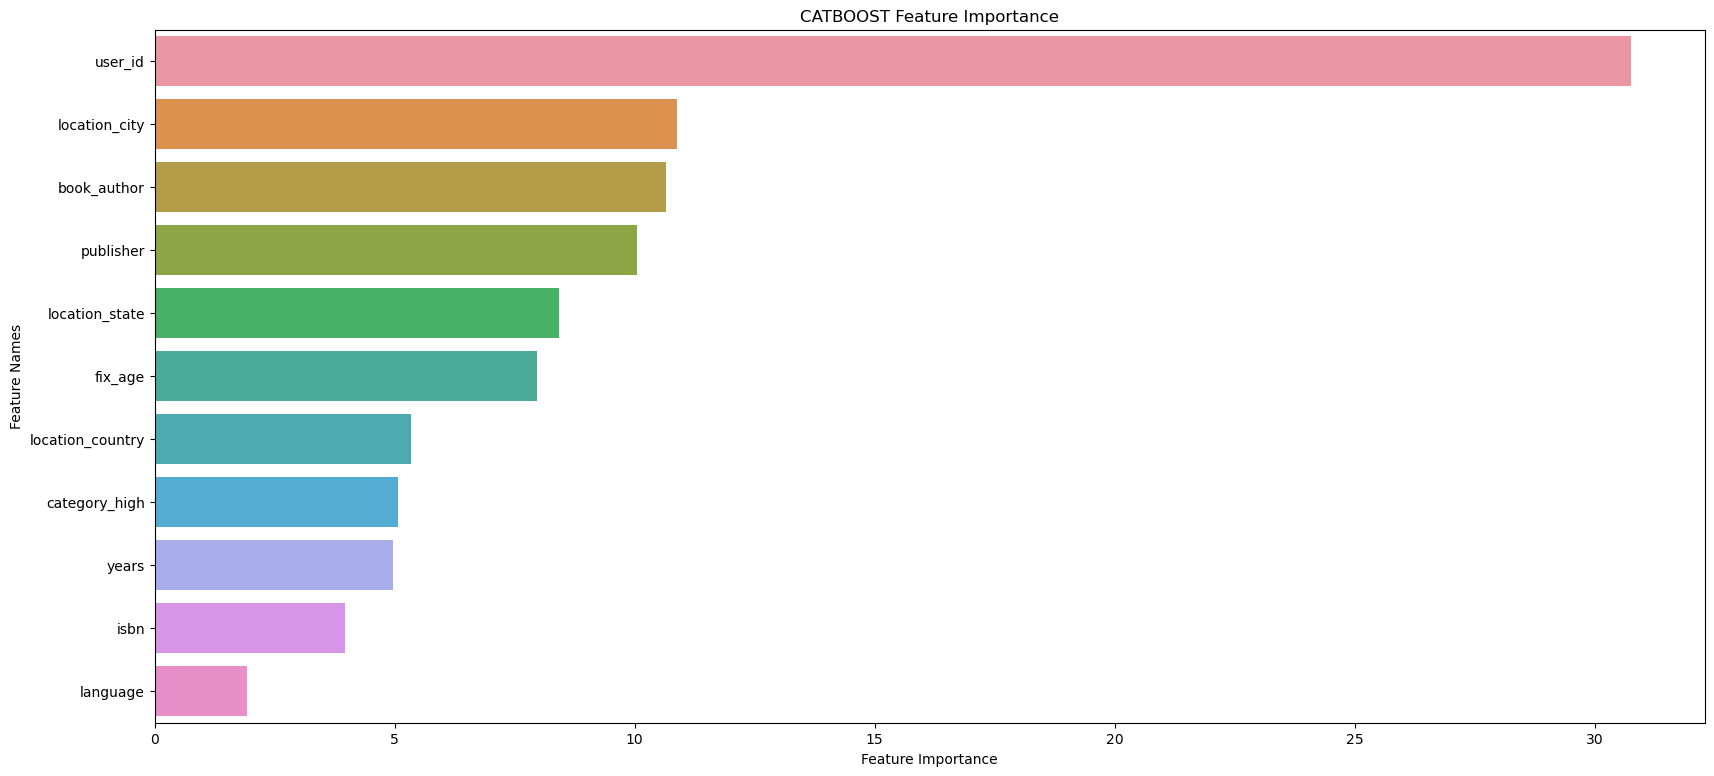

In [128]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')